In [60]:
 # Required package to load data 
import xarray as xr
import os 
import datetime as dt

# Required packages for ploting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature.nightshade import Nightshade

import subprocess
import glob
import pandas as pd 
# In order to run the 'wget' command, wget needs to be available. 
# On a Windows machine, it is probably easiest to simply place the 'wget.exe' file 
# (see https://www.gnu.org/software/wget/) in the same directory as this Norebook

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

In [62]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [64]:
outline = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
for layer in [outline]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [3]:
# Define function to run wget command
def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

In [16]:
def run_download(url,verbose=False):
    cmd = 'wget -c --no-check-certificate -r -np -nH --user=daafip --password=Joyfully-Distant-Backer7' 
    cmd += ' -nd -R "*nd" ' # Only -nd relevant for METREF ### 15.nc, *30.nc, *45.nc
    cmd += url

    runcmd(cmd, verbose=verbose);

In [24]:
import datetime

In [27]:
datetime.datetime(2016, 1, 1)

datetime.datetime(2016, 1, 1, 0, 0)

In [17]:
day=10
url = f'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDMET/NETCDF/2023/03/{day}/'

In [66]:
run_download(url,verbose=False)

In [69]:
files = glob.glob("*.nc")
ds = xr.open_mfdataset(files)

In [78]:
ds.sel(lat=slice(-75,-70),lon=slice(40,50))

<xarray.Dataset>
Dimensions:                 (time: 1, lat: 0, lon: 201)
Coordinates:
  * lat                     (lat) float32 
  * lon                     (lon) float32 40.0 40.05 40.1 ... 49.9 49.95 50.0
  * time                    (time) datetime64[ns] 2023-03-10
Data variables:
    ET                      (time, lat, lon) float64 dask.array<chunksize=(1, 0, 201), meta=np.ndarray>
    crs                     |S1 ...
    max_nslots_missing      (time, lat, lon) float64 dask.array<chunksize=(1, 0, 201), meta=np.ndarray>
    missing_values_percent  (time, lat, lon) float64 dask.array<chunksize=(1, 0, 201), meta=np.ndarray>
Attributes: (12/27)
    date_created:               2023-03-11T00:28:54Z
    algorithm_version:          2.0.0
    base_algorithm_version:     0.5.4
    processing_level:           04
    platform:                   MSG4
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

<GeoAxesSubplot: title={'center': 'time = 2023-03-10'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

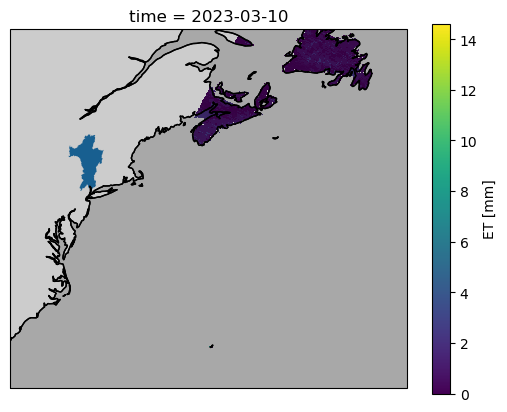

In [68]:
# to avoid showing warnings of cartopy
import warnings
warnings.filterwarnings('ignore')

slot=dt.datetime(2023,3,29,0,0)
# slot = lst_xr[3]
pvar = ds.ET.isel(time=0)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
ax.coastlines()
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.add_feature(Nightshade(slot, alpha=0.2))
# ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.75, draw_labels=False)
ax.set_xlim((-80,-50))
ax.set_ylim((30,50))
outline.plot(ax=ax)

clearly falls outside our area

Not what we want

In [ ]:
def evaporation(area, df, index):
    """
        takes an index and computes the volume water evaorated per day using given df
        Note precipitation has negligible salts, so ignored. 
    """
    LAMBDA = 2.45 * 10**6                           # MJ/kg
    RHO_AIR = 1.205                                 # density of air (kg/m3)
    RHO_W = 1000                                    # density of water (kg/m3)
    GAMMA = 0.066                                   # psychrometer constant (kPa/C) 
    C_P = 1004                                      # specifc heat of air at constant pressure (J/kg/K)
    
    u = df.loc[index, "wind_speed"]                 # m/s
    t = df.loc[index, "temperature"]                # deg
    rnet = df.loc[index, "rnet"] * 3600 * 24        # w/m^2 to: net radiation on the earth's surface (J/d/m^2): 1W = J/s
    RH =  df.loc[index, "RH"]/100                   # Relative humidity in %   
    
#     RH = 0.75
#     t = 20
#     u = 10.5
#     rnet = 20*10**6
    
    es = 0.61 * np.exp(19.9 * t /(t + 273.15))      # KPA
    ea = es * RH                                    # KPA
    s = ((5430 * es) / ((t + 273.15)**2))           # slope of the saturation vapour pressure-temperature curve (kPa/C)
    r_a = 245/(0.54 * u + 0.5)/86400
    
    numer =  ((s * rnet) / (RHO_W * LAMBDA)) + ((C_P * RHO_AIR * (es - ea))/(RHO_W * LAMBDA * r_a))
    denom = s + GAMMA
    E_p = numer / denom  # m/d
#     print(E_p)
    volume = E_p * area 
                                                
    return volume # m^3